In [89]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import pandas as pd
import scipy.interpolate
import plotly.express as px
from math import sqrt
import os
import random

In [90]:
def return_folder_paths(file_name):
    """
    @returns paths to raw and caliberated folders of that particular day file
    You need to work in the same location as the day files
    """
    raw_files_path = f'./{file_name}/xsm/data/{file_name[8:12]}/{file_name[12:14]}/{file_name[14:16]}/raw'
    calibrated_files_path = f'./{file_name}/xsm/data/{file_name[8:12]}/{file_name[12:14]}/{file_name[14:16]}/calibrated'
    return raw_files_path, calibrated_files_path

In [91]:
# files = os.listdir('./')
# flag = True
# valid_dirs = []
# for file in files:
#     if file[:3] == 'ch2':
#         valid_dirs.append(file)

# # random.seed(0)
# file = random.choice(valid_dirs)
# raw, calib = return_folder_paths(file)
# path_to_lc = calib + '/' + file + '_level2.lc'

In [92]:
path_to_lc = "./ch2_xsm_20211107_v1/xsm/data/2021/11/07/calibrated/ch2_xsm_20211107_v1_level2.lc"
path_to_lc

'./ch2_xsm_20211107_v1/xsm/data/2021/11/07/calibrated/ch2_xsm_20211107_v1_level2.lc'

In [93]:
def lightcurve(file, should_plot=False):
    t = Table.read(file)
    tmp = t["RATE"]
    if should_plot:
        plt.figure(figsize=(25, 7))
        plt.scatter(range(len(tmp)), tmp, s=1)
    return tmp

In [94]:
def plot_as_plotly(_x, _y, _title):
    _df = pd.DataFrame(zip(_x, _y))
    _df.columns = ['X-Axis', 'Y-Axis']
    _fig = px.line(_df, x='X-Axis', y='Y-Axis', title=_title)
    _fig.show()
    return

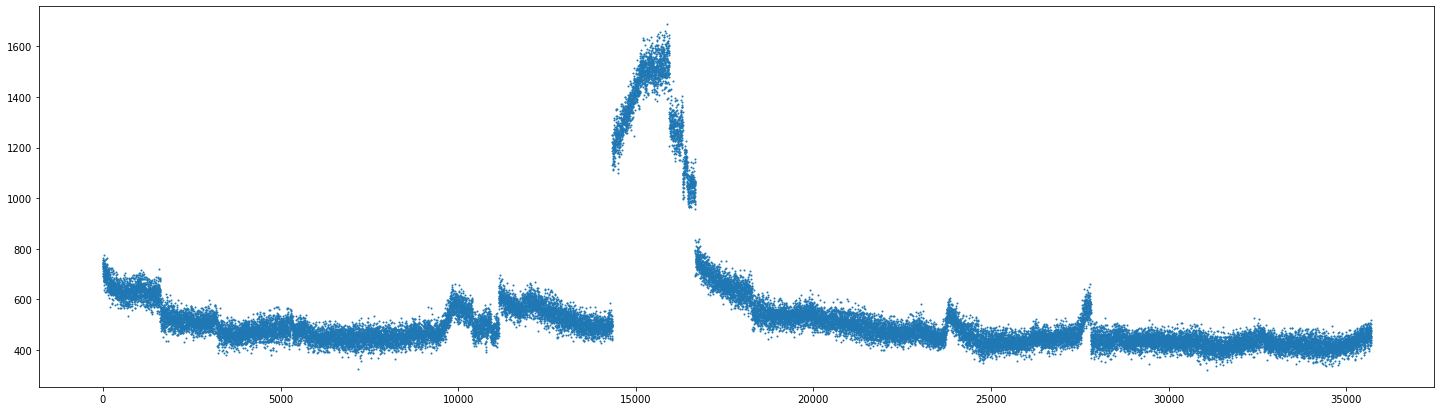

In [95]:
rand_lc = lightcurve(path_to_lc, True)

## MODULE - 1: DETECTION

### Smoothening the graph

In [96]:
window_sz = 40
new_norm = []
new_norm_data_points = []
for i in range(1, len(rand_lc), window_sz):
    tmp = np.mean(rand_lc[i:i+window_sz])
    new_norm.append(tmp)
    new_norm_data_points.append(i)

new_norm = np.array(new_norm)
new_norm_data_points = np.array(new_norm_data_points)

plot_as_plotly(new_norm_data_points, new_norm, 'After Windowizing, Not Smooth')

In [97]:
sz = new_norm.shape[0]
tck, u = scipy.interpolate.splprep([new_norm_data_points, new_norm], s=0)
xnew, ynew = scipy.interpolate.splev(np.linspace(0, 1, len(rand_lc)), tck, der=0)

plot_as_plotly(xnew, ynew, 'Smooth version, Spline treatment')

In [98]:
def smoothen_fft(lc, thresh=200, should_plot=False):
    lc_fft = np.fft.fft(lc)
    lc_fft[thresh:len(lc)-thresh]=0
    lc_smooth = np.abs(np.fft.ifft(lc_fft))
    if should_plot:
        px.line(pd.DataFrame(lc_smooth))
    return lc_smooth

In [100]:
ynew = smoothen_fft(rand_lc, should_plot=True)

In [101]:
ynew

array([588.66731384, 591.37697689, 594.08401039, ..., 580.53393754,
       583.24465718, 585.95616118])

### Finding level 0 extremas

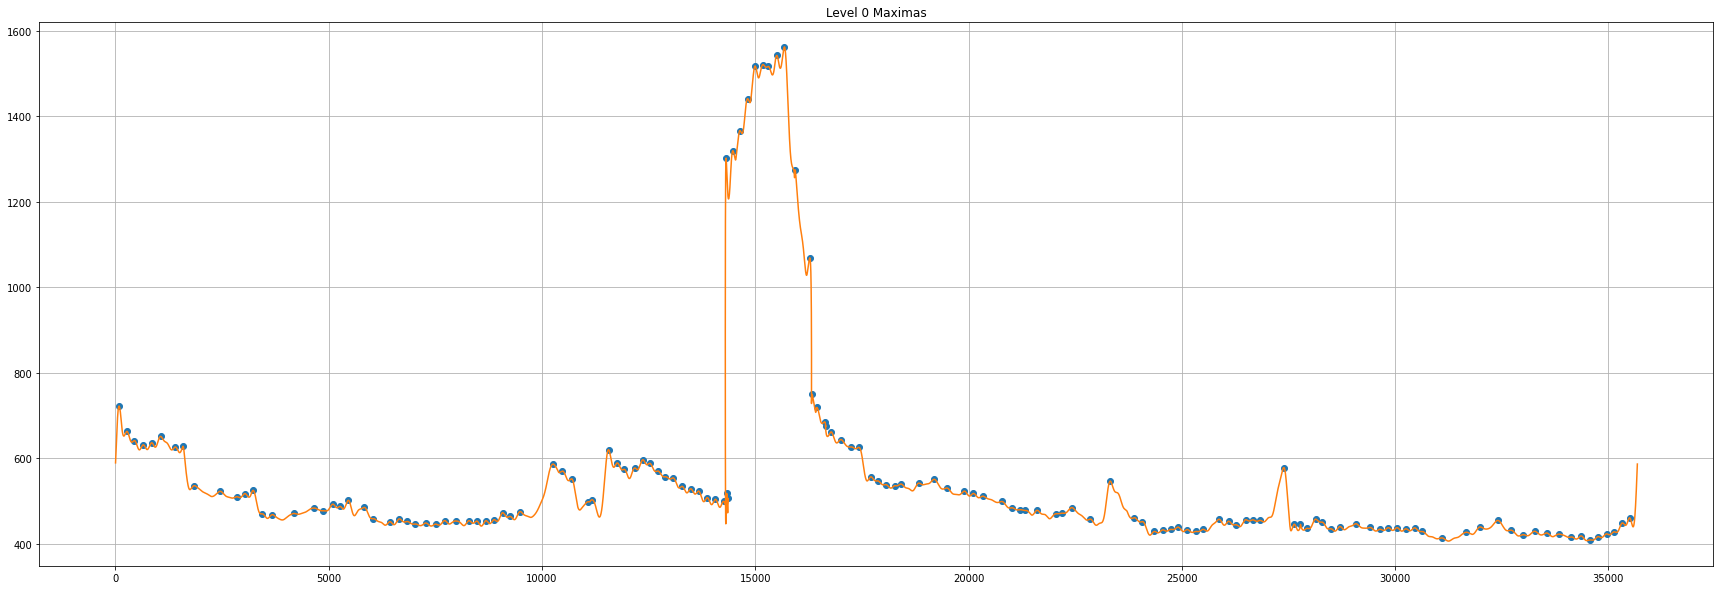

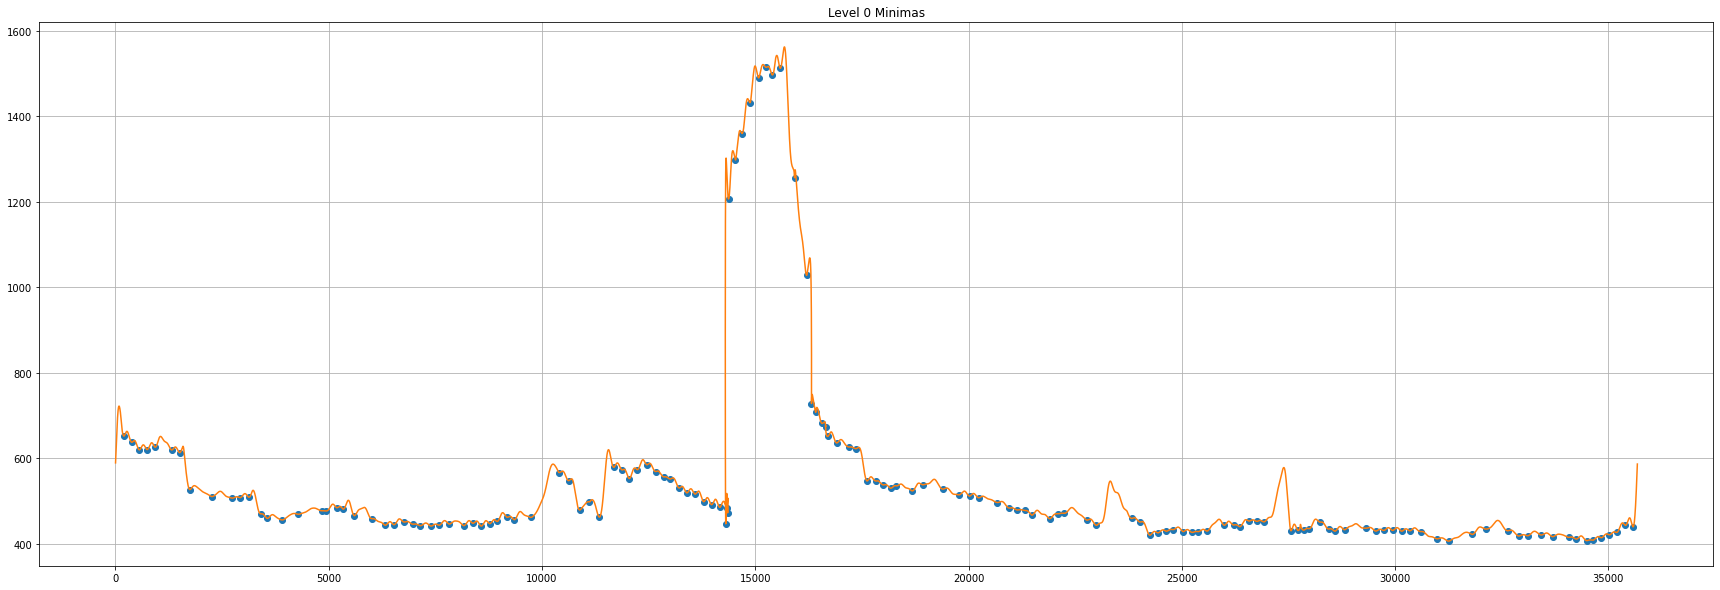

In [102]:
_s0 = []
_p0 = []

for i in range(1, len(ynew)-1):
    if (ynew[i]>ynew[i-1]) and (ynew[i]>ynew[i+1]):
        _p0.append(i)
    elif (ynew[i]<ynew[i-1]) and (ynew[i]<ynew[i+1]):
        _s0.append(i)

plt.figure(figsize=(30, 10))
plt.grid()
plt.title("Level 0 Maximas")
plt.plot([xnew[i] for i in _p0], [ynew[i] for i in _p0], 'o', xnew, ynew)
plt.show()

plt.figure(figsize=(30, 10))
plt.grid()
plt.title("Level 0 Minimas")
plt.plot([xnew[i] for i in _s0], [ynew[i] for i in _s0], 'o', xnew, ynew)
plt.show()

In [103]:
max_before_min = 0
if (xnew[_s0[0]] < xnew[_p0[0]]):
    max_before_min = 1

### Cleaning to get level 1 extremas

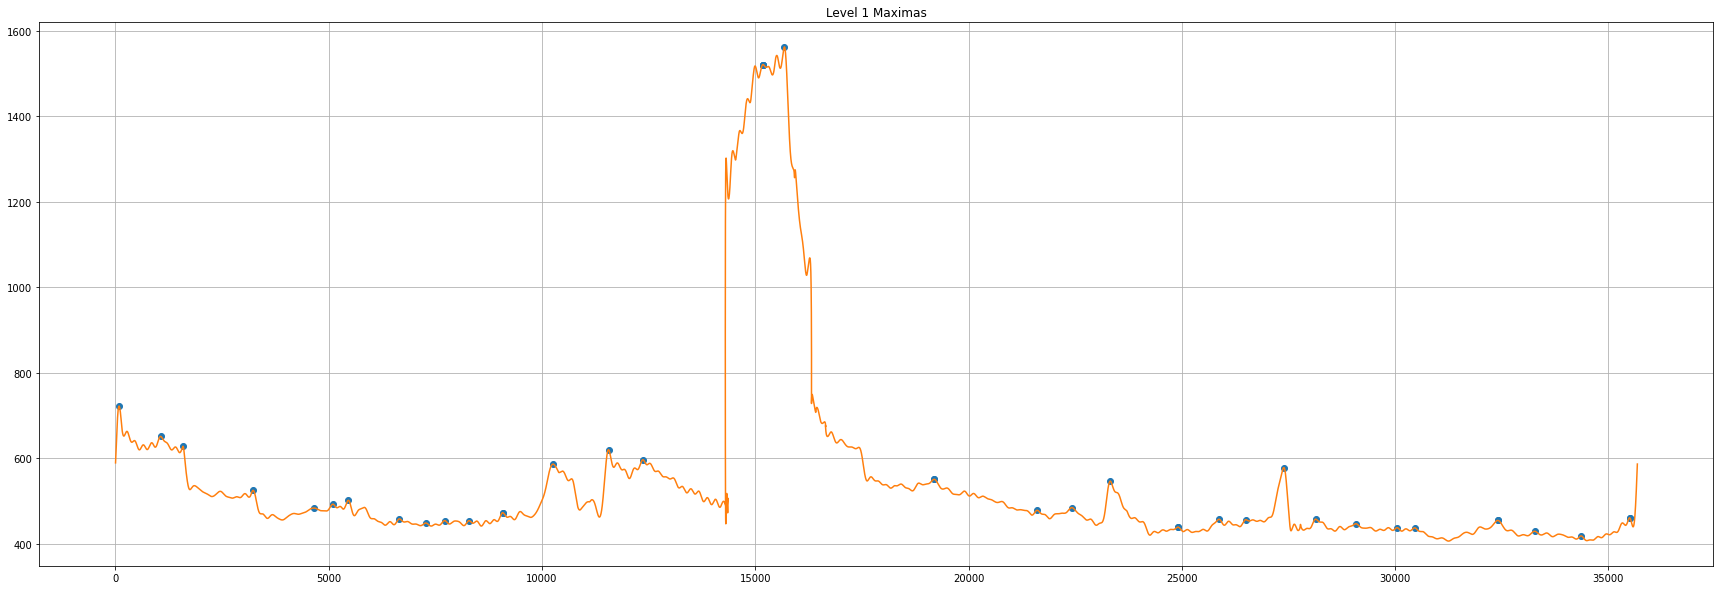

In [104]:
_p1 = []

l = len(_p0)
is_increasing = True

for i in range(l-1):
    if is_increasing:
        while (i < l-1) and (ynew[_p0[i]] < ynew[_p0[i+1]]):
            i += 1
        _p1.append(_p0[i])
        is_increasing = False
    else:
        if (i < l-1):
            if (ynew[_p0[i]] < ynew[_p0[i+1]]):
                is_increasing = True

plt.figure(figsize=(30, 10))
plt.title("Level 1 Maximas")
plt.grid()
plt.plot([xnew[i] for i in _p1], [ynew[i] for i in _p1], 'o', xnew, ynew)
plt.show()

In [105]:
def get_slope(x1, x2, y1, y2):
    return ((y1-y2) / (x1-x2))

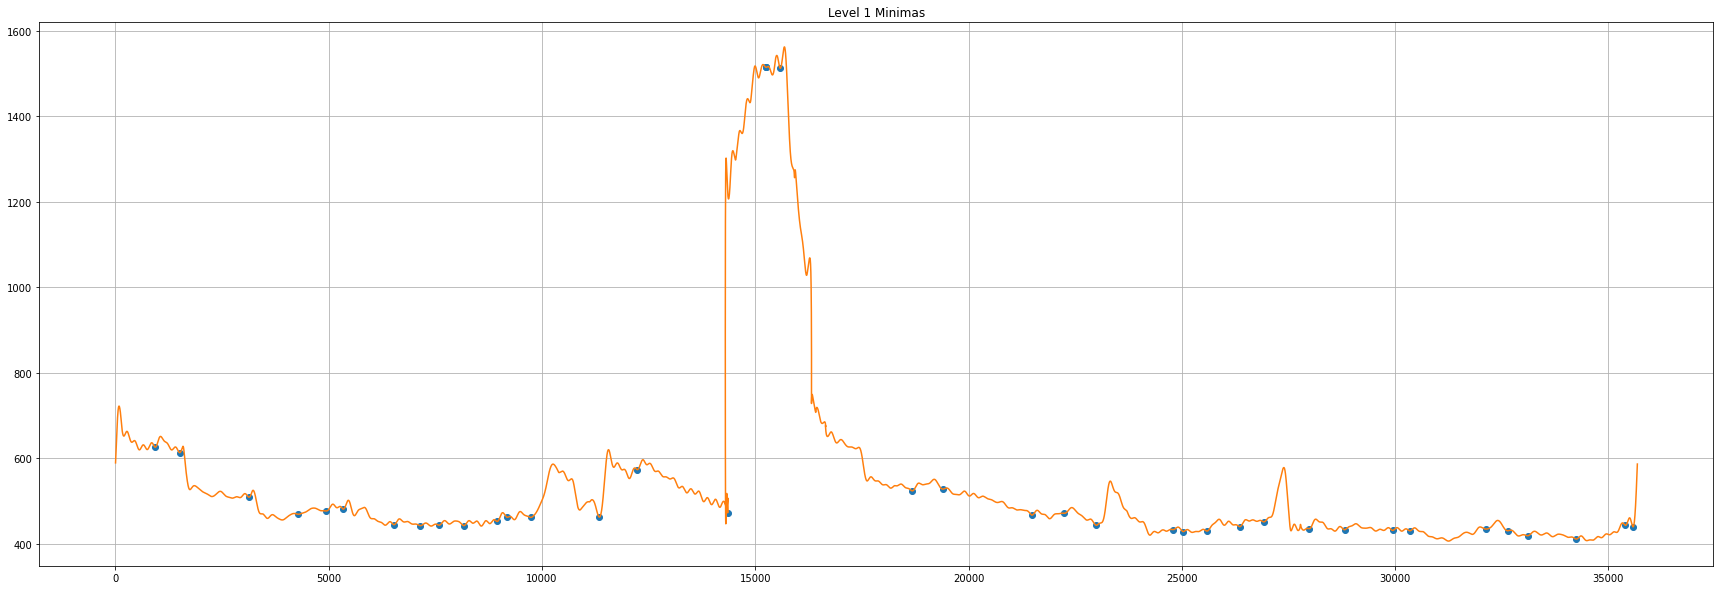

In [106]:
_s1 = []

for i in range(1, len(_p1)):
    k = 0
    for j in range(len(_s0)):
        if (xnew[_s0[j]] > xnew[_p1[i]]):
            k = j
            break
    tmp_sl = get_slope(xnew[_s0[k]], xnew[_p1[i]], ynew[_s0[k]], ynew[_p1[i]])
    tmp_val = _s0[k]
    while (xnew[_s0[k]] > xnew[_p1[i-1]]):
        t_sl = get_slope(xnew[_s0[k]], xnew[_p1[i]], ynew[_s0[k]], ynew[_p1[i]])
        if (t_sl > tmp_sl):
            tmp_sl = t_sl
            tmp_val = _s0[k]
        k -= 1
        if k<0:
            break
    _s1.append(tmp_val)

plt.figure(figsize=(30, 10))
plt.grid()
plt.title("Level 1 Minimas")
plt.plot([xnew[i] for i in _s1], [ynew[i] for i in _s1], 'o', xnew, ynew)
plt.show()

### Pairing for better access (level 2 extremas)

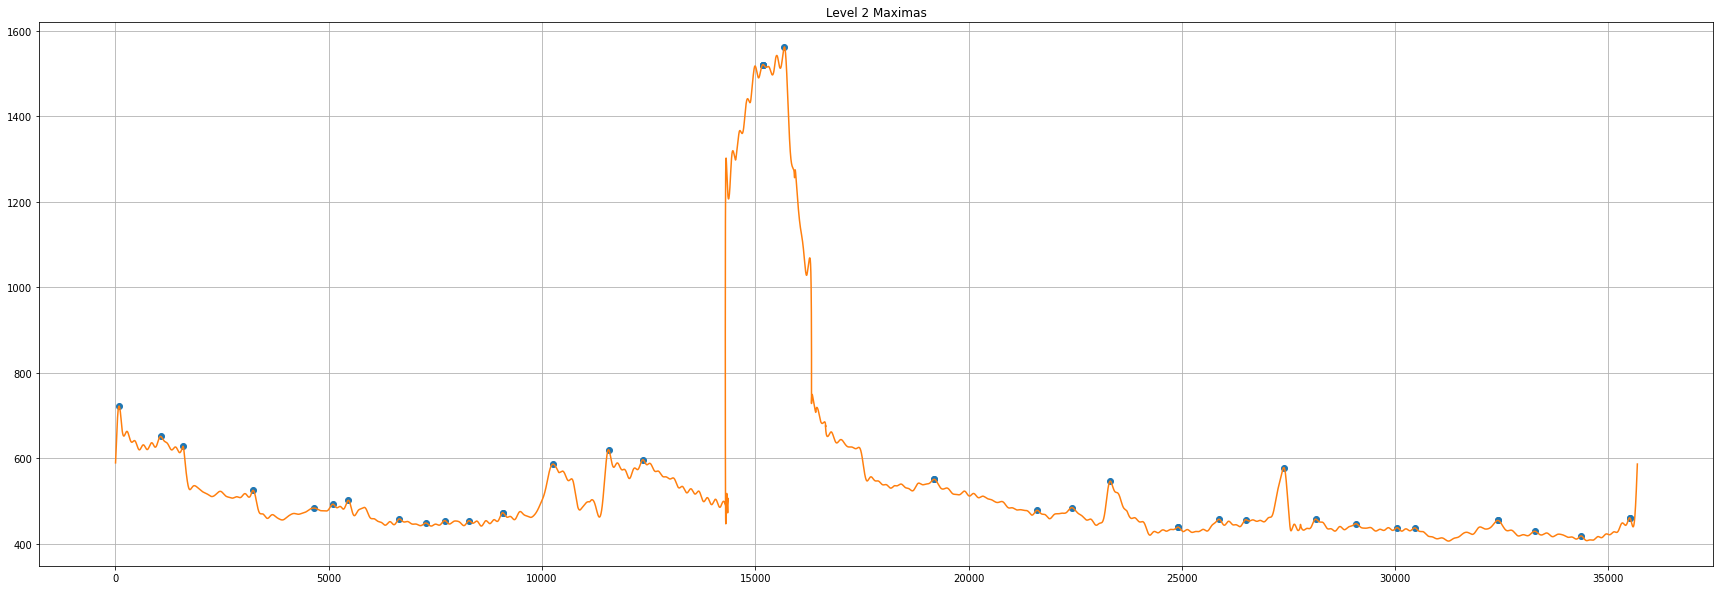

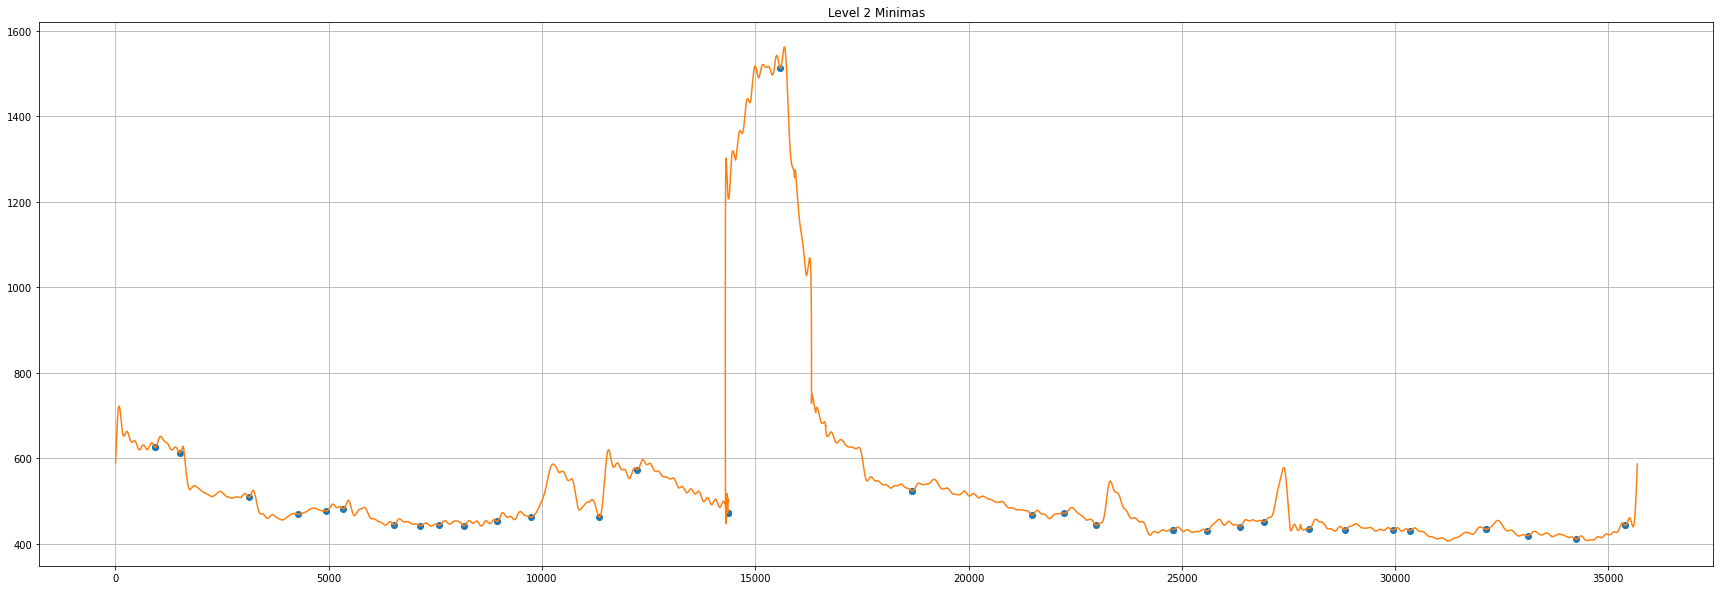

In [107]:
_s2 = []
_p2 = []

for i in range(len(_p1)):
    for j in range(len(_s1)-1):
        if (xnew[_s1[j+1]] > xnew[_p1[i]]):
            _s2.append(_s1[j])
            _p2.append(_p1[i])
            break

plt.figure(figsize=(30, 10))
plt.grid()
plt.title("Level 2 Maximas")
plt.plot([xnew[i] for i in _p2], [ynew[i] for i in _p2], 'o', xnew, ynew)
plt.show()

plt.figure(figsize=(30, 10))
plt.grid()
plt.title("Level 2 Minimas")
plt.plot([xnew[i] for i in _s2], [ynew[i] for i in _s2], 'o', xnew, ynew)
plt.show()

### Filtering to yield level 3 extremas

In [108]:
def pythagorean(x1, x2, y1, y2):
    _y = (y1-y2)*(y1-y2)
    _x = (x1-x2)*(x1-x2)
    return sqrt(_x + _y)

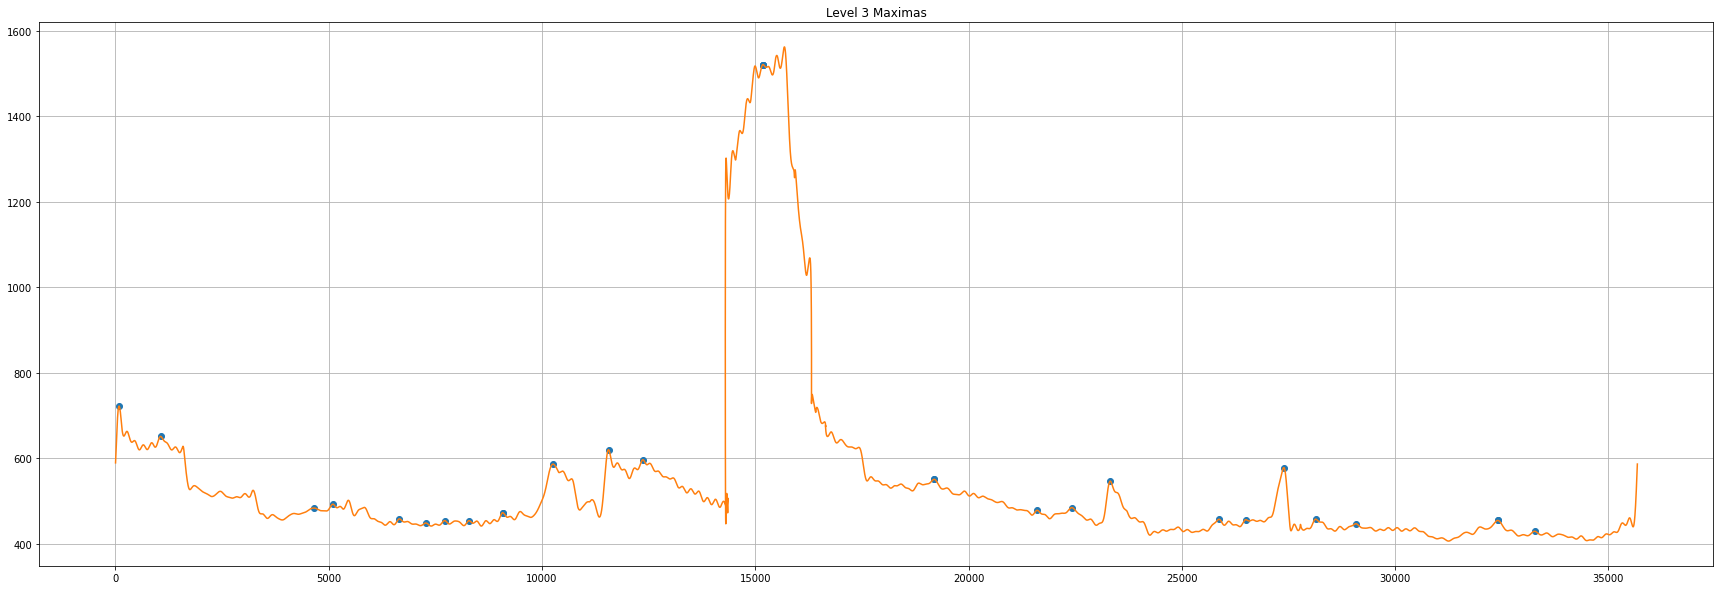

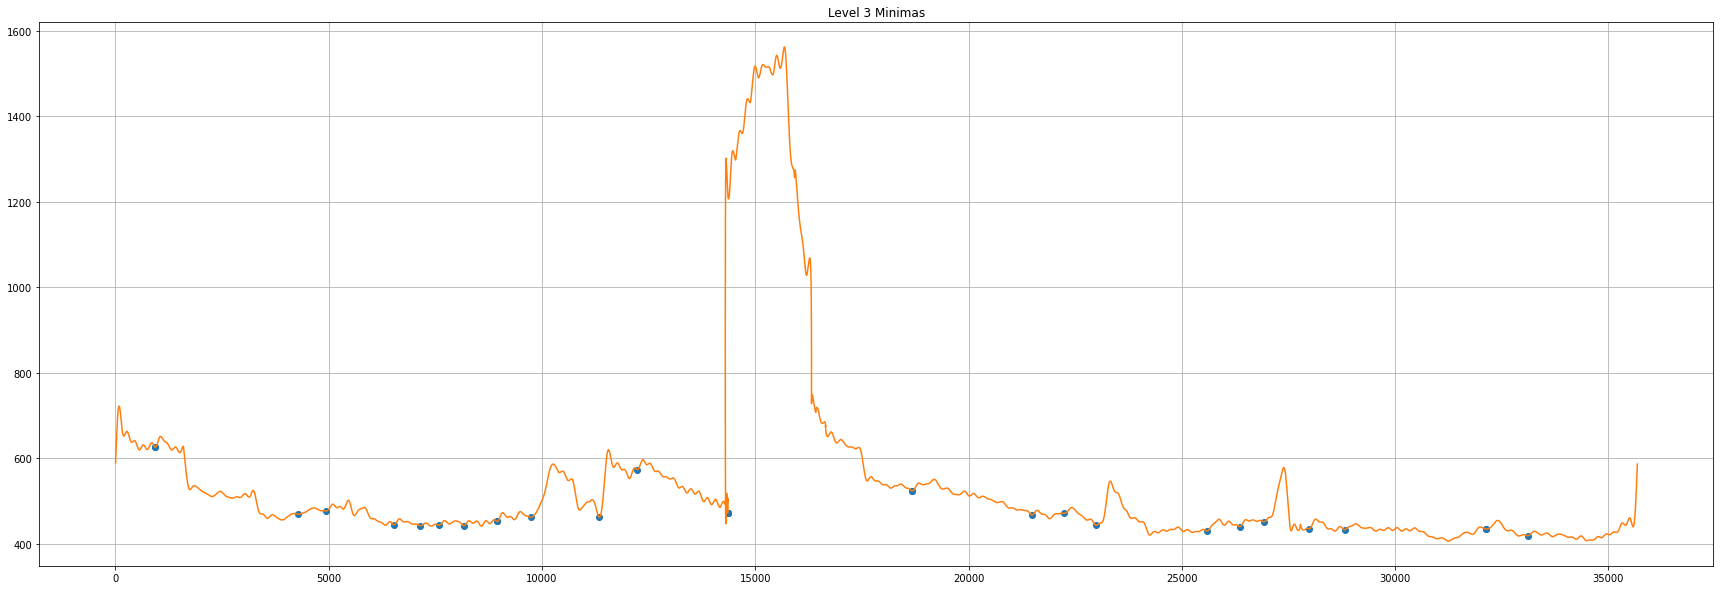

In [109]:
_s3 = []
_p3 = []

s = np.std(ynew)
threshold_radius = s * 0.53
for i in range(len(_p2)-1):
    x = pythagorean(xnew[_s2[i]], xnew[_p2[i]], ynew[_s2[i]], ynew[_p2[i]])
    if (x > threshold_radius):
        _s3.append(_s2[i])
        _p3.append(_p2[i])

plt.figure(figsize=(30, 10))
plt.grid()
plt.title("Level 3 Maximas")
plt.plot([xnew[i] for i in _p3], [ynew[i] for i in _p3], 'o', xnew, ynew)
plt.show()

plt.figure(figsize=(30, 10))
plt.grid()
plt.title("Level 3 Minimas")
plt.plot([xnew[i] for i in _s3], [ynew[i] for i in _s3], 'o', xnew, ynew)
plt.show()

### Removing Duplicates to finally get level 4 extremas

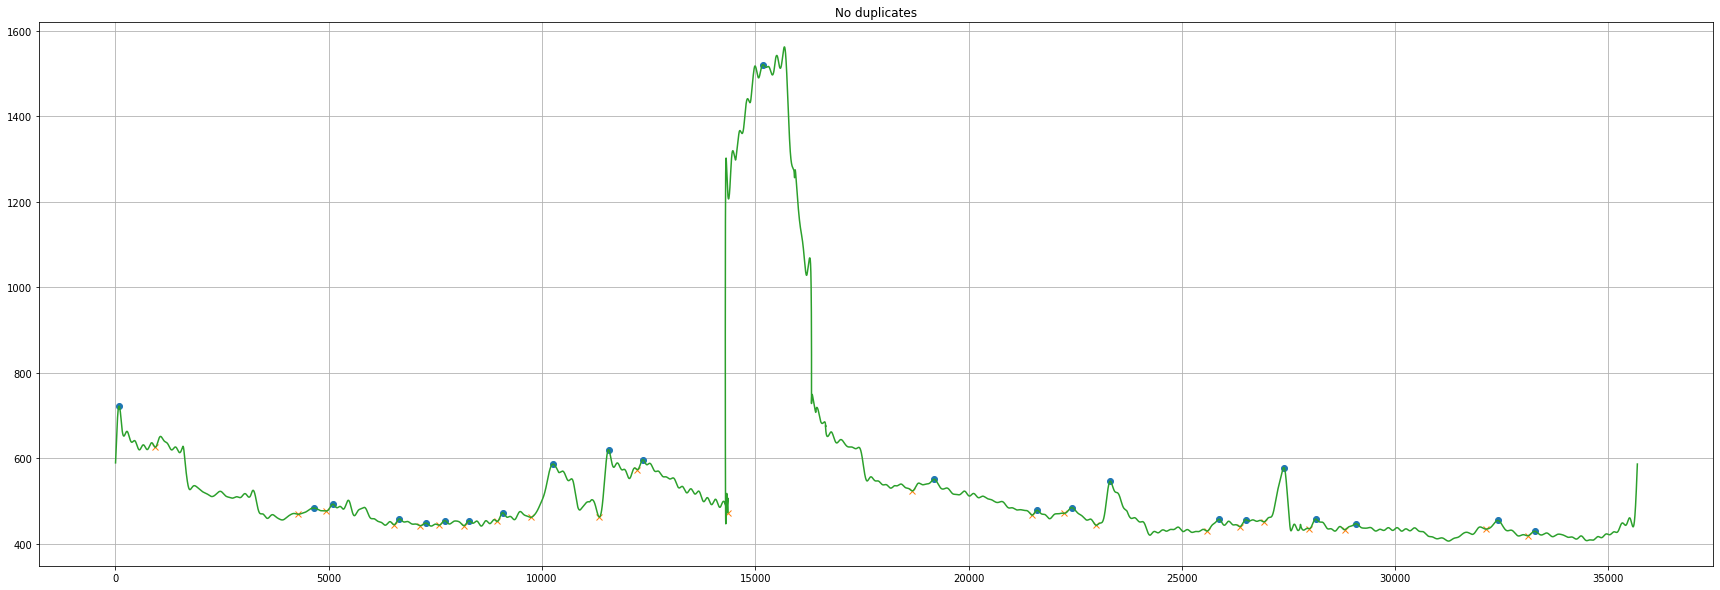

In [110]:
_s4 = []
_p4 = []

s = set()

for i in range(len(_s3)):
    if _s3[i] in s:
        continue
    s.add(_s3[i])
    _s4.append(_s3[i])
    _p4.append(_p3[i])

plt.figure(figsize=(30, 10))
plt.grid()
plt.title("No duplicates")
plt.plot([xnew[i] for i in _p4], [ynew[i] for i in _p4], 'o', [xnew[i] for i in _s4], [ynew[i] for i in _s4], 'x', xnew, ynew)
plt.show()

### Finding level 0 ends

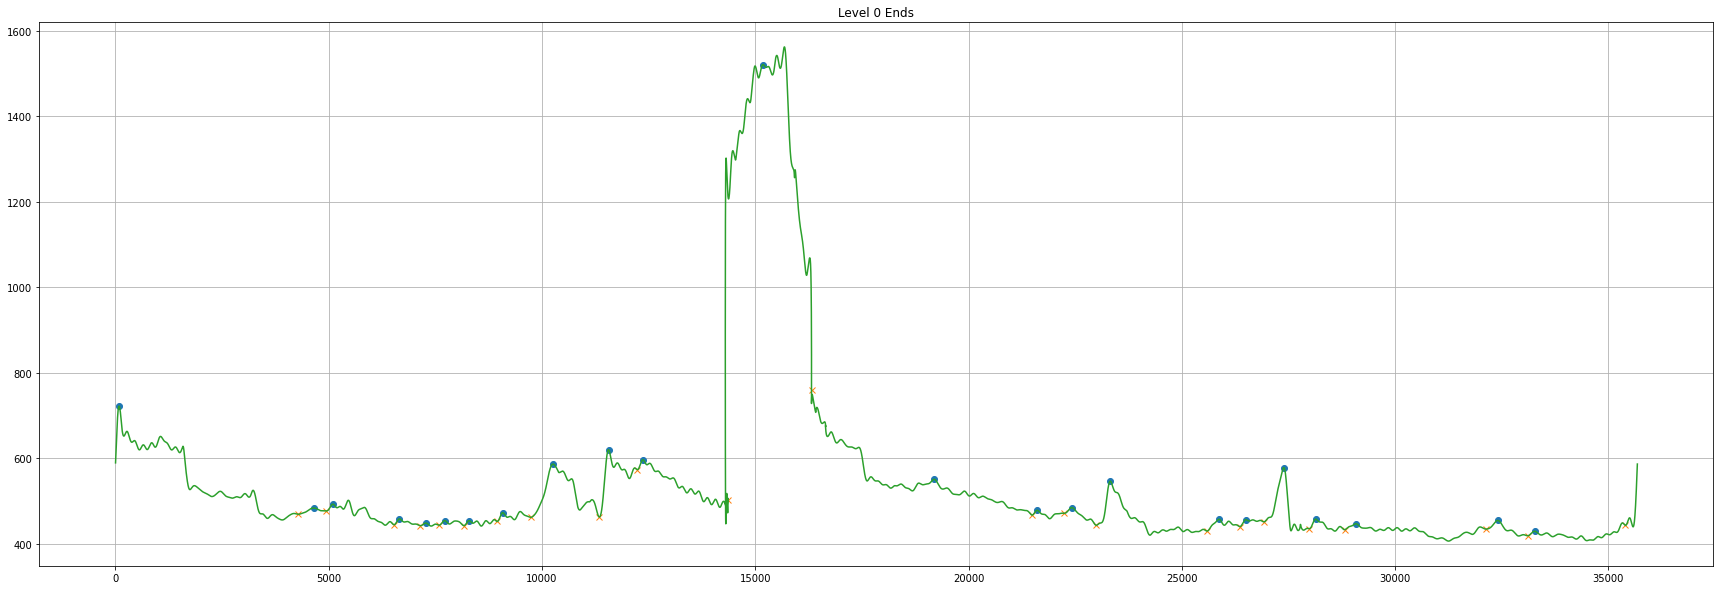

23

In [111]:
_e0 = []

for i in range(len(_p4)-1):
    for j in range(len(xnew)):
        if (xnew[j] > xnew[_p4[i]]):
            if (ynew[j] < ynew[_p4[i]]/2):
                _e0.append(j)
                break
            if (xnew[j] > xnew[_s4[i+1]]):
                _e0.append(j-1)
                break

_e0.append(_s2[-1])

plt.figure(figsize=(30, 10))
plt.grid()
plt.title("Level 0 Ends")
plt.plot([xnew[i] for i in _p4], [ynew[i] for i in _p4], 'o', [xnew[i] for i in _e0], [ynew[i] for i in _e0], 'x', xnew, ynew)
plt.show()

len(_e0)

### Fixing to get level 1 ends

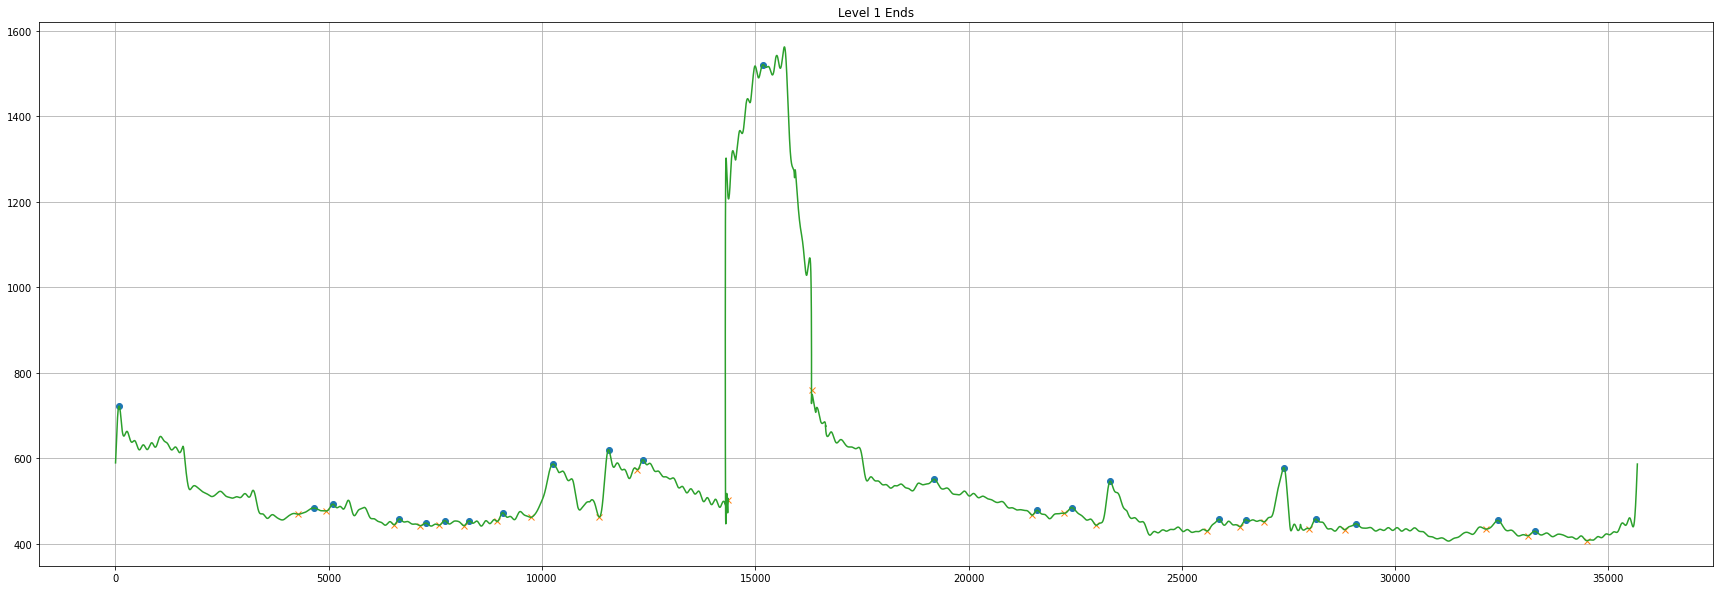

In [112]:
_e1 = []

for i in range(len(_e0)):
    if (ynew[_e0[i]] < ynew[_p4[i]]):
        _e1.append(_e0[i])
    else:
        for j in range(len(_s0)):
            if (xnew[_s0[j]] > xnew[_p4[i]]):
                if (ynew[_s0[j+1]] > ynew[_s0[j]]):
                    _e1.append(_s0[j])
                    break

plt.figure(figsize=(30, 10))
plt.grid()
plt.title("Level 1 Ends")
plt.plot([xnew[i] for i in _p4], [ynew[i] for i in _p4], 'o', [xnew[i] for i in _e1], [ynew[i] for i in _e1], 'x', xnew, ynew)
plt.show()

### Final Zip

In [113]:
start_times = []
peak_times = []
end_times = []
peak_intensities = []

for i in range(len(_s4)):
    if (_p4[i]-_s4[i] > 0) and (_e1[i]-_p4[i] > 0):
        start_times.append(_s4[i])
        peak_times.append(_p4[i])
        end_times.append(_e1[i])
        peak_intensities.append(ynew[_p4[i]])

final_zip = pd.DataFrame(zip(start_times, peak_times, end_times, peak_intensities))
final_zip.columns = ['start_time', 'peak_time', 'end_time', 'peak_intensity']
final_zip

,start_time,peak_time,end_time,peak_intensity
0,4137,4482,4763,482.947073
1,4763,4911,6304,491.975148
2,6304,6424,6892,457.607463
3,6892,7012,7308,447.917658
4,7308,7431,7857,453.546786
5,7857,7972,8606,453.473916
6,8606,8731,9368,472.051634
7,9368,9869,11022,585.721010
8,11022,11226,11877,619.509099
9,11877,11999,13964,596.052760


### Plotting the graph of each "Detected Peak"

In [114]:
st = final_zip['start_time']
pt = final_zip['peak_time']
et =  final_zip['end_time']
pi = final_zip['peak_intensity']

# for i in range(len(final_zip)):
#     plt.figure(figsize=(4, 4))
#     plt.grid()
#     plt.plot(xnew[st[i]:et[i]], ynew[st[i]:et[i]])
#     plt.show()

## MODULE - 2: CURVE FITTING

In [115]:
from scipy.optimize import curve_fit
from math import exp

In [116]:
k = 0.6

def exp_fit_func(x, ln_a, b):
    t = (x ** k)
    return (ln_a - b*t)

def exp_func(x, a, b):
    t = -1 * b * (x ** k)
    return (a * np.exp(t))

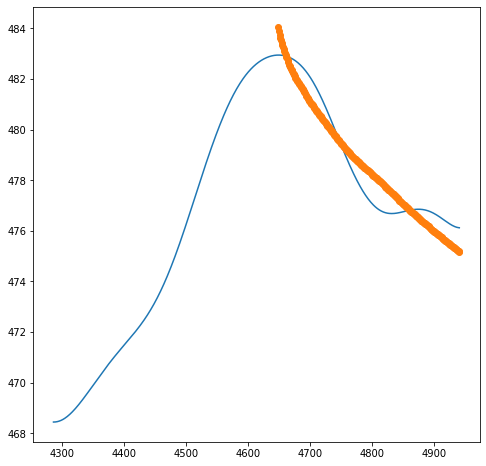

0.6600986368713978


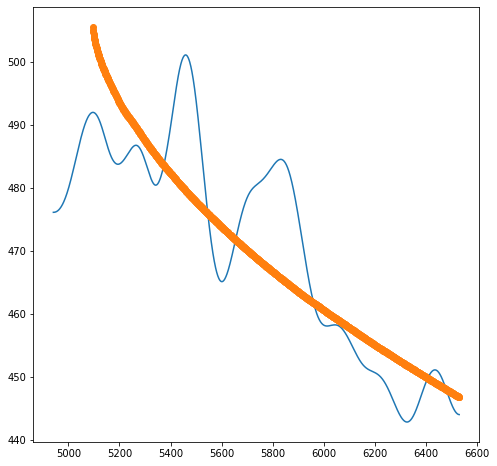

7.140082562992751


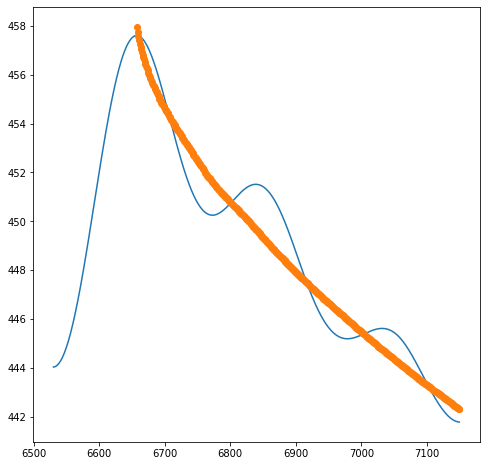

0.8852630630293161


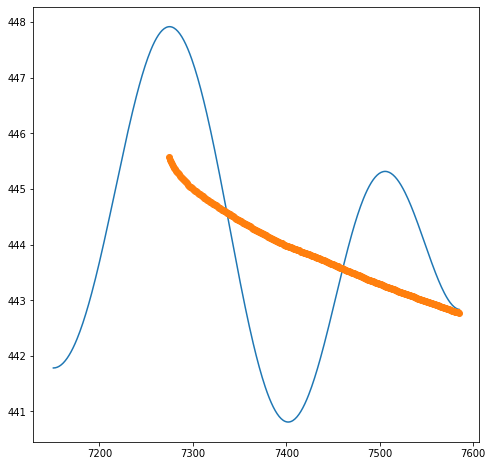

1.6222629674222284


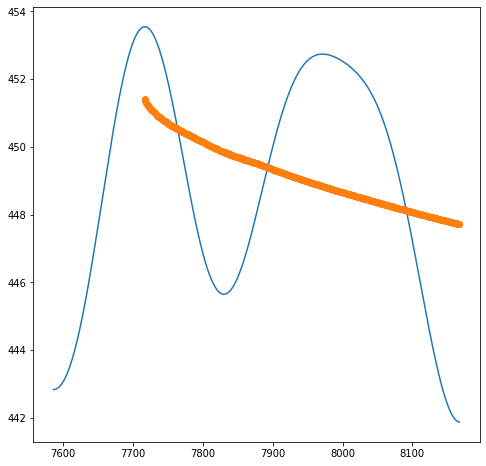

2.7546203564792036


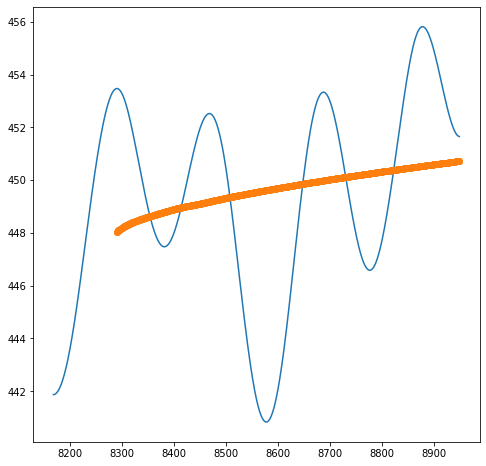

3.0508370501557307


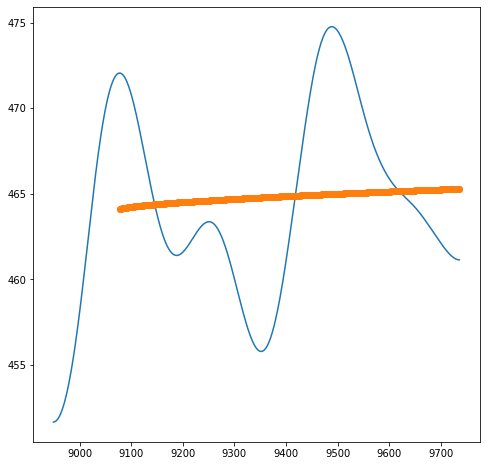

4.131828400551858


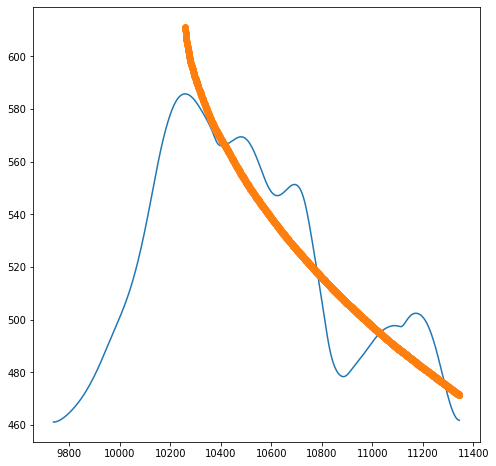

12.633440534457087


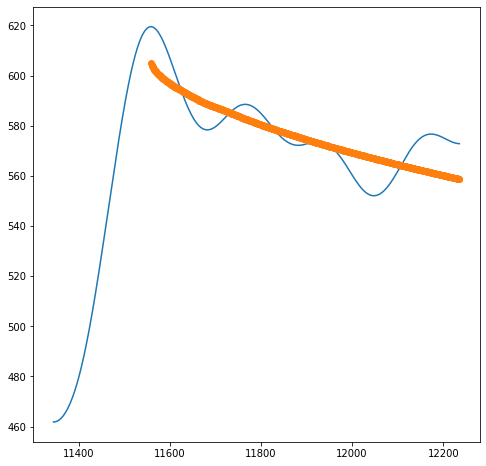

7.310346406732442


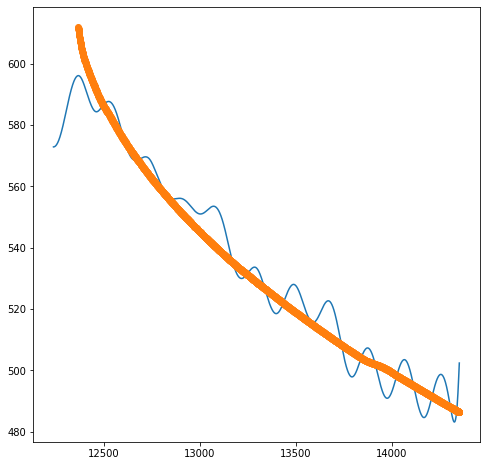

4.919064033248961


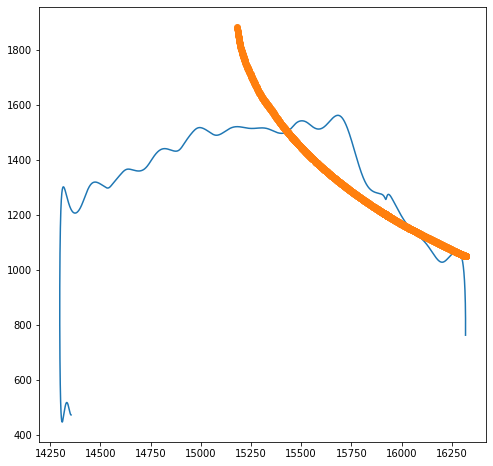

93.92270118466085


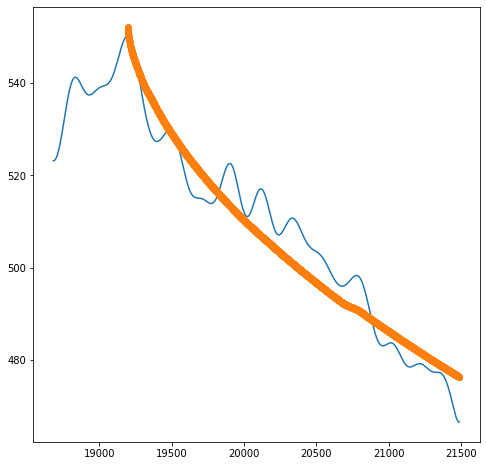

4.760963460711978


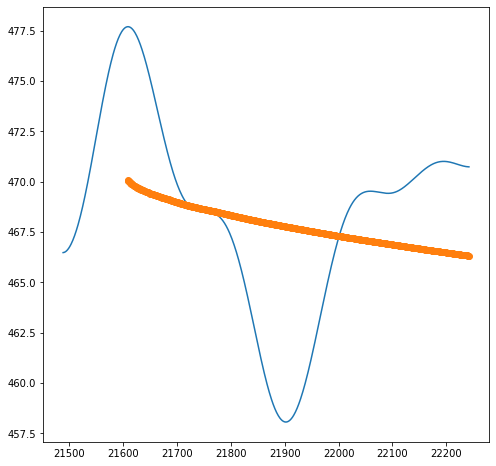

3.7766694347535075


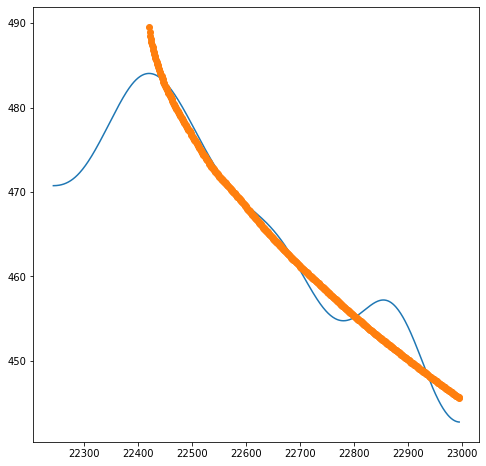

1.6932349925509578


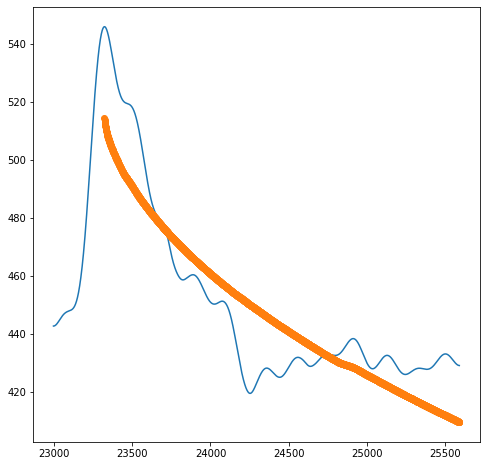

12.26962658946474


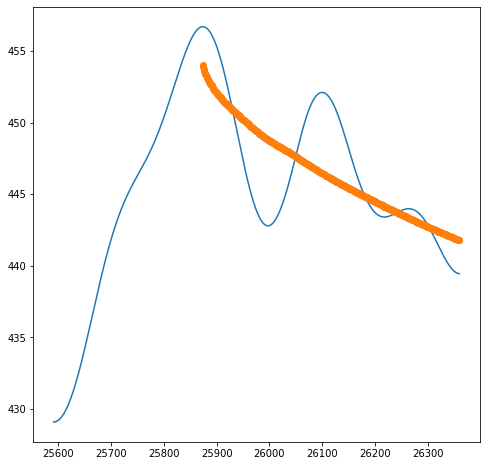

2.4745255702153295


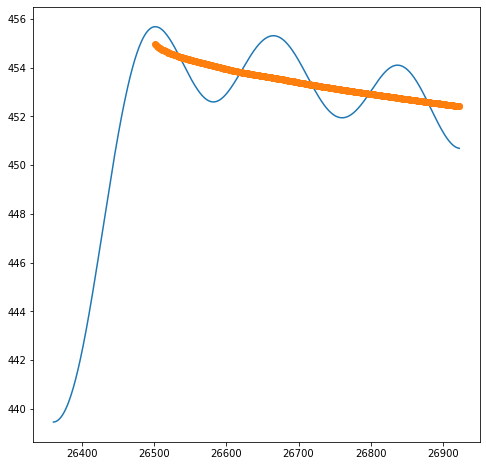

0.9111996912552469


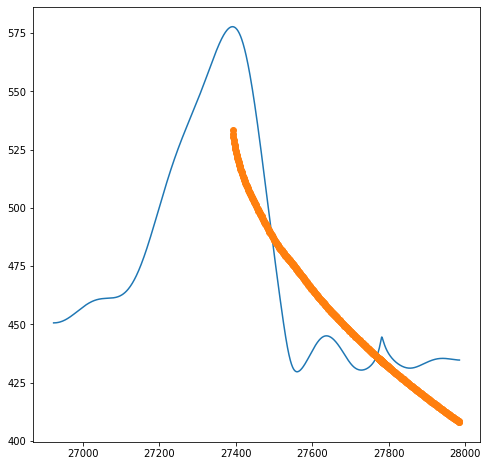

19.65148535800097


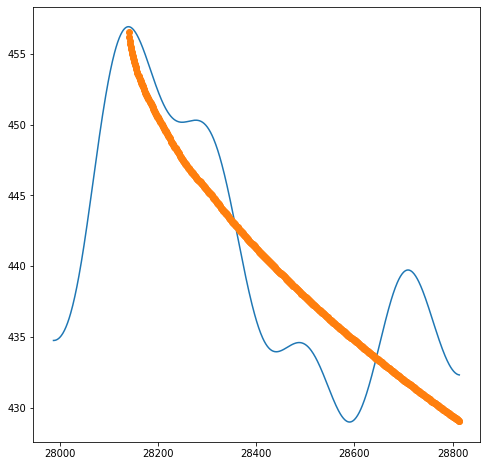

4.069807618115912


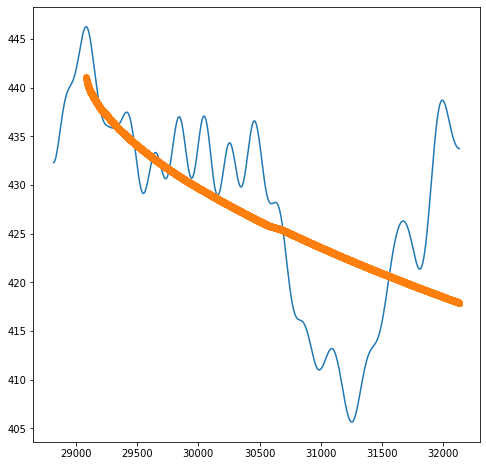

6.278672961403766


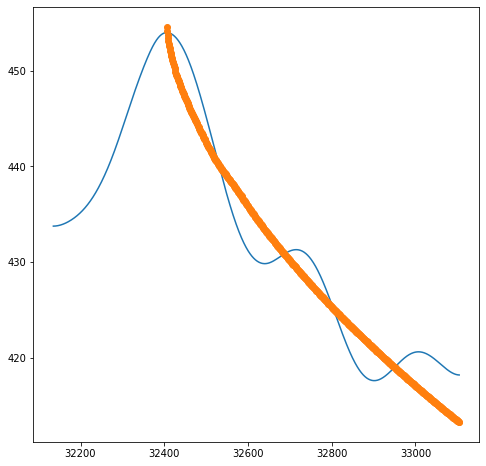

2.812031937825909


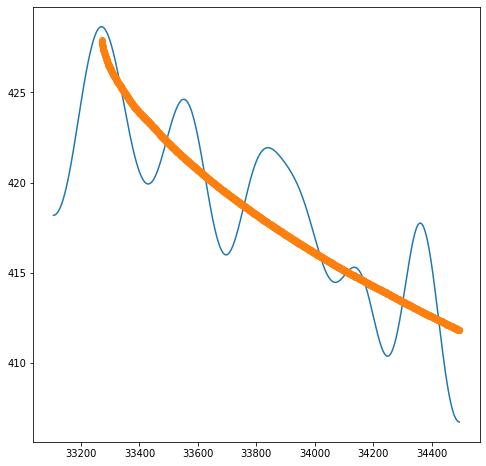

2.217740610522486


In [117]:
for i in range(len(st)):
    x_range = [int(xnew[j]-xnew[pt[i]]) for j in range(pt[i], et[i])]
    ln_y_range = [np.log(ynew[j]) for j in range(pt[i], et[i])]
    
    popc, pcov = curve_fit(exp_fit_func, x_range, ln_y_range)
    ln_a, b = popc
    a = np.exp(ln_a)

    y_dash = []
    y_diff = []
    for _i, j in enumerate(x_range):
        __y = exp_func(xnew[j], a, b)
        y_dash.append(__y)
        y_diff.append(abs(exp(ln_y_range[_i]) - __y))

    plt.figure(figsize=(8, 8))
    plt.plot(xnew[st[i]:et[i]], ynew[st[i]:et[i]], '-', xnew[pt[i]:et[i]], y_dash, 'o')
    plt.show()

    _y_ = np.array(y_diff)
    print(np.mean(_y_))